#### Climaturk Storm Finder: Quantile Algorithm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import salem
import warnings
import functools
import operator
warnings.filterwarnings("ignore")

In [ ]:
tp = xr.open_dataset(r'D:\JupyterLab\Climaturk_Site\Docs\STORM_DATA\precipitation\era5_turkey_clipped_2010_2020')

In [3]:
# resample hourly values to daily total values in mm
precip = tp.resample(time='1D').sum() * 1000 

In [41]:
class ClimaturkStormFinderERA5:
    def __init__(self):
        self.storm_dates = []   
    
    def get_subset_data(self, data, portion):
        """Documentation"""
        if portion not in ['lu', 'lb', 'ru', 'rb']:
            return "ERROR: portion argument has to be either: lu, lb, ru, rb"
        
        half_latitude_index = int(len(data.latitude)/2)
        half_longitude_index = int(len(data.longitude)/2)
        
        if portion == 'lu':
            data_portion  = data.isel(latitude=slice(0, half_latitude_index), longitude=slice(0, half_longitude_index))
            
        elif portion == 'lb':
            data_portion  = data.isel(latitude=slice(half_latitude_index, -1), longitude=slice(0, half_longitude_index))
            
        elif portion == 'ru':
            data_portion  = data.isel(latitude=slice(0, half_latitude_index), longitude=slice(half_longitude_index, -1))
            
        elif portion == 'rb':
            data_portion  = data.isel(latitude=slice(half_latitude_index, -1), longitude=slice(half_longitude_index, -1))
        return data_portion
    
    def compute_quantiles_monthly(self, subset_data, month, quantile):
        """Documentation"""
        self.month = month
        self.quantile = quantile
    
        
        self.data_monthly = subset_data.sel(time=subset_data.time.dt.month==self.month)
        return self.data_monthly.quantile(q=self.quantile, dim='time')
        
    def compute_storm_dates(self, subset_data, month, quantile, grid_percent=0.1):
        """Documentation"""
        quantile_data = self.compute_quantiles_monthly(subset_data, month, quantile)
        #self.storm_dates[f'quantile{self.quantile}'] = []
        
        for timestep in range(len(self.data_monthly.time)):
            
            #True-False flattened array
            date_boolean = np.where(self.data_monthly[timestep].values>quantile_data, True, False).flatten()

            # check if the date_boolean contains True; if not continue iterating
            if True not in np.unique(date_boolean) :
                continue
                
            true_count = np.count_nonzero(date_boolean == True)
            false_count = np.count_nonzero(date_boolean == False)
    
            # check if boolean contains at least (grid_percent)% True values
            if not true_count/(true_count + false_count) >= grid_percent:
                continue
            #if np.any(self.data_monthly[timestep]>quantile_data):
            
            computed_date = pd.to_datetime(str(self.data_monthly.time[timestep].values)).strftime("%Y%m%d")
            self.storm_dates.append(computed_date)
        return self.storm_dates

In [166]:
# binary search
def binary_search_algorithm(data, to_find,):
    
    if len(data) == 0:
        return False
    
    low, high = 0, len(data)-1
    
    while low <= high:
        mid = (low + high) // 2
        #print(mid)
        
        if data[mid] == to_find:
            return True
    
        if data[mid] > to_find:
            high = mid - 1 
            
        elif data[mid] < to_find:
            low = mid + 1
            
    return False



In [160]:
# ilk döngü quantile daha sonra month daha sonra subset
months = np.arange(1, 13, 1)
quantile_list = [0.99, 0.95, 0.9]
subset_list = ['lu', 'lb', 'ru', 'rb']
new_df = {}
raw_date_list = []

dates_count = 0
for q in quantile_list:
    new_df[q] = []
   
    for m in months:
        
        for sub in subset_list:
            
            
            # start instance
            instance = ClimaturkStormFinderERA5()
            
            # subset the data
            subset = instance.get_subset_data(precip['tp'], sub)
            
            # compute storm dates
            dates = instance.compute_storm_dates(subset, month=m, quantile=q, grid_percent=0.1)
            #print(1)
            
            new_df[q].append(dates)
            #if set(dates).intersection(functools.reduce(operator.iconcat, raw_date_list, [])):
            #    continue
    
for q in quantile_list:
    new_df[q] = list(set(functools.reduce(operator.iconcat, new_df[q], [])))
    print(f'unique datelist of quantile:{q} is = {len(new_df[q])}')

unique datelist of quantile:0.99 is = 45
unique datelist of quantile:0.95 is = 382
unique datelist of quantile:0.9 is = 868


In [167]:
print(868/3650) # 10 yılın yüzde 23 i giriyor bu sınıfa

0.2378082191780822


In [161]:
def datelist_for_html(pd_data):
    outer_dict = {}

    for y in range(2010, 2020):

        inner_dict = {}
        for m in range(1, 13):

            inner_dict[str(m)] = []
            for d in range(1, 31):

                for i in range(len(pd_data)):

                    year = str(pd_data[i][:4])
                    month = int(str(pd_data[i][4:6]))
                    day = int(str(pd_data[i][6:]))
                    


                    if str(year) + str(month) + str(day) == str(y) + str(m) + str(d):

                        inner_dict[str(m)].append(str(d))

        outer_dict[str(y)] = inner_dict
    return outer_dict

In [162]:
q99_html_datelist = datelist_for_html(new_df[0.99])
q95_html_datelist = datelist_for_html(new_df[0.95])
q90_html_datelist = datelist_for_html(new_df[0.9])

In [168]:
pd.DataFrame(q90_html_datelist)

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
1,"[3, 4, 14, 18, 19, 20, 22, 24, 25]","[7, 13, 14, 15, 25, 27, 27, 28, 29, 29, 30]","[1, 7, 9, 10, 12, 15, 16, 17, 18, 19, 21, 22, ...","[6, 7, 8, 12, 17, 19, 19, 26, 27, 28]","[11, 12, 21, 25, 26, 27, 29, 29]","[5, 6, 7, 12, 13, 19, 22]","[4, 5, 7, 8, 11, 13, 14, 17, 18, 19, 21, 22, 2...","[5, 7, 8, 10, 15, 16, 16, 26, 26, 27]","[1, 15, 18, 19, 21, 22, 25, 26]","[3, 4, 6, 8, 11, 15, 16, 21, 24, 25, 26]"
2,"[2, 3, 4, 7, 8, 21, 22, 27, 28]","[15, 19, 20, 23, 26]","[1, 7, 9, 14, 15, 17, 18, 27, 28, 29]","[6, 8, 11, 18, 20, 22, 28]","[14, 25]","[2, 9, 10, 11, 17, 18, 20, 23, 24]","[5, 6, 7, 21, 22]",[],"[17, 18, 25, 26, 28]","[1, 6, 7, 9, 26, 28]"
3,"[3, 6, 15]","[6, 7, 8, 9, 18, 21]","[12, 13, 30]","[4, 12, 15, 17, 22, 23]","[3, 4, 5, 9, 10, 29]","[11, 12, 14, 20, 21, 24, 27, 28, 29, 30]","[3, 4, 5, 14, 19, 20, 25, 28]","[2, 9, 10, 11, 12, 14, 18]","[1, 4, 8, 9, 24, 28, 29]","[12, 14, 15, 16, 24, 29, 30]"
4,"[7, 11, 12, 20, 21, 27, 28, 30]","[2, 3, 4, 5, 10, 11, 12, 14, 18, 19, 22, 23, 2...","[10, 11, 14, 15, 16, 18]","[3, 4, 8, 10, 15, 16, 19, 20]","[11, 18, 28, 30]","[7, 8, 9, 20, 23]","[11, 21, 26]","[8, 9, 13, 14, 18, 23]",[10],"[9, 10, 11, 14, 15, 16, 17, 20, 21]"
5,"[1, 22, 23]","[1, 2, 4, 5, 6, 12, 13, 27, 28, 29]","[3, 4, 5, 6, 25]","[10, 11, 12, 13, 14]","[5, 8, 9, 30]","[8, 9, 10, 12, 27, 29]","[3, 4, 5, 6, 15, 22, 23, 27, 28]","[2, 3, 6, 7, 18, 19, 20, 22, 23, 27]","[5, 6, 7, 8, 9, 10, 11, 12, 13, 26, 29, 30]","[2, 3, 4, 24]"
6,"[6, 7, 8, 9, 10, 11, 23, 24, 25]","[1, 6, 11, 13, 14, 15]",[],[10],"[1, 2, 3, 5, 6, 7, 8, 9, 10, 12]","[2, 3, 4, 6, 7, 8, 10, 11, 19, 26, 27]","[7, 8, 9, 15, 16, 18, 19]","[4, 5, 9, 14, 18, 19]","[1, 2, 4, 13, 14, 15, 16, 19, 20, 21]","[10, 12, 15, 17, 18, 19, 20]"
7,"[8, 9, 16, 17, 23, 24]","[2, 12, 16, 17, 18, 19, 20, 22, 23, 24]","[2, 3, 4, 8, 9, 29, 30]","[16, 17, 18]","[5, 16, 18, 19, 20, 21, 26]",[2],"[4, 5, 6, 7, 8, 20, 21]","[4, 18, 19, 28]","[15, 18, 24, 25, 26, 27]","[11, 12, 14, 15, 17, 18]"
8,"[5, 26]","[11, 12, 20]","[1, 2, 4, 6, 7, 12, 28]","[23, 24]","[4, 5, 6, 7, 8, 18, 19]","[1, 4, 6, 7, 9, 10, 11, 15, 22, 24, 25, 28, 29...","[4, 5, 6, 13, 25, 26]","[3, 4, 5, 6, 16, 17, 21, 22, 30]","[2, 3, 4, 8, 29]","[15, 17, 18, 20, 21, 30]"
9,"[1, 13, 22, 23, 25, 30]","[22, 23, 24, 25, 26, 27, 29, 30]","[1, 2, 9, 10, 12]","[4, 17, 18, 19, 21, 22, 23]","[6, 8, 10, 17, 18, 19, 20, 23, 24, 27, 28, 29]","[12, 20, 21, 22, 23, 28, 29, 30]","[13, 15, 16, 20, 21, 22, 23]","[6, 30]","[6, 10, 13, 14, 29, 30]","[6, 14, 15, 25]"
10,"[3, 7, 8, 9, 13, 14, 15, 19, 20, 28, 29, 30]","[9, 10, 11, 12, 13, 16, 17, 19]","[10, 11, 23, 24, 25, 26]","[1, 2, 3, 4, 17, 18, 19]","[12, 14, 15, 16, 18, 19, 24, 25, 26, 29, 30]","[2, 6, 7, 13, 22, 23, 24, 25, 26, 27]",[28],"[1, 2, 8, 24, 25, 28, 29, 30]","[13, 21, 23, 24, 25, 26]","[6, 21, 29]"


In [ ]:
already_exists = np.load(r'../src/Old_Datelists/DateList_Precipitation_{}_v1.npy'.format('10042021'), allow_pickle = True)[:,0]

In [331]:
brand_new = np.load(r'../src/DateList_Synoptic_10042021.npy', allow_pickle=True)[:, 0]

In [345]:
common_dates = list(set(already_exists).intersection(set(brand_new)))
old_but_not_new_dates = list(set(already_exists).difference(set(brand_new)))
not_old_but_new_dates = list(set(brand_new).difference(set(already_exists)))

In [393]:
len(already_exists), len(common_dates), len(old_but_not_new_dates), len(not_old_but_new_dates)

(373, 312, 61, 556)

In [391]:
import os
import shutil

mypath = r'D:\JupyterLab\Climaturk_Site'
precipitation_path = mypath + r'\Docs\STORMS\precipitation'
synoptic_path = mypath + r'\Docs\STORMS'
thermodynamic_path = mypath + r'\Codes\SkewT_Pictures'

path_lists = [precipitation_path, 
              synoptic_path,
              thermodynamic_path]

for path in path_lists:
    
    try:
        os.mkdir(os.path.join(path, 'Temporary_old_dirs_storage'))
    except:
        pass
        
    # old stuff
    for single_path in common_dates + old_but_not_new_dates:
        to_be_moved = os.path.join(path, single_path)
        target = os.path.join(path, 'Temporary_old_dirs_storage')
        #shutil.move(to_be_moved, target)

#### Exercise

In [518]:
len(climaturk.storm_dates['quantile0.9'])

37

In [523]:
climaturk.storm_dates['quantile0.9'][0]

<xarray.DataArray 'time' ()>
array('2010-02-02T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2010-02-02

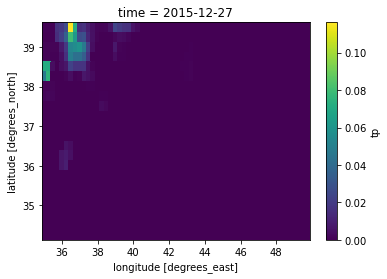

In [165]:
subset.sel(time='2015-12-27T00:00:00.000000000').plot()